# Control Phase — Monitoring & Drift Detection Simulation

**Project:** Employee Attrition Prediction (DMAIC Framework)  
**Notebook:** 06_control.ipynb  
**Purpose:** Simulate production monitoring with statistical process control (SPC) tools

This notebook demonstrates:
- p-chart for prediction proportions
- EWMA for metric trends
- Page-Hinkley change detection
- PSI (Population Stability Index) for feature drift
- KL-divergence for categorical features
- Optional ADWIN streaming drift detector

**Note:** This simulates monitoring on historical data split into batches. In production, replace with live data streams.

---

## ⚠️ Important: Run Instructions

**Before running this notebook:**
1. **Restart the kernel** (Kernel → Restart)
2. **Run all cells in sequence** from top to bottom (Cell → Run All)
3. Do NOT run cells individually or out of order

**Why?** The model expects all 34 original features from the raw CSV. Running cells out of order may cause `ValueError: columns are missing` errors.

In [1]:
# Cell 1 — Setup and imports
RANDOM_SEED = 42

import os, json, time, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    roc_auc_score, accuracy_score, confusion_matrix, 
    average_precision_score
)
from sklearn.utils import resample
from scipy.stats import entropy

# Create output directories
os.makedirs('../figures', exist_ok=True)
os.makedirs('../tables', exist_ok=True)
os.makedirs('../reports', exist_ok=True)

sns.set(style='whitegrid')
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f'Setup complete. Random seed: {RANDOM_SEED}')

Setup complete. Random seed: 42


In [2]:
# Cell 2 — Load model and historical labeled data
import joblib

MODEL_PATH = '../models/final_attrition_pipeline.pkl'
DATA_PATH = '../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv'

# Load final model
pipeline = joblib.load(MODEL_PATH)
print(f'Model loaded from {MODEL_PATH}')

# Load data
df = pd.read_csv(DATA_PATH)
target_col = 'Attrition'

# Encode target if needed
if df[target_col].dtype == object:
    df[target_col] = df[target_col].map({'Yes': 1, 'No': 0})

# IMPORTANT: Keep ALL 34 features - the pipeline expects them
# Do NOT drop EmployeeCount, Over18, or StandardHours
# The model was trained with all features present

# Shuffle to simulate sequential batches
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print(f'Data shape: {df.shape}')
print(f'Attrition rate: {df[target_col].mean():.3f}')
print(f'Features (excluding target): {df.shape[1] - 1}')

Model loaded from ../models/final_attrition_pipeline.pkl
Data shape: (1470, 35)
Attrition rate: 0.161
Features (excluding target): 34


In [3]:
# Cell 3 — Create time-batches to simulate daily/weekly production
n_batches = 30
batch_size = int(np.ceil(len(df) / n_batches))
batches = [df.iloc[i*batch_size:(i+1)*batch_size].copy() for i in range(n_batches)]

print(f'Created {len(batches)} batches')
print(f'Typical batch size: ~{batch_size} observations')
print(f'Batch size range: {min(len(b) for b in batches)} to {max(len(b) for b in batches)}')

Created 30 batches
Typical batch size: ~49 observations
Batch size range: 49 to 49


In [4]:
# Cell 4 — Compute per-batch metrics
THRESHOLD = 0.388  # Optimal threshold from 05_final_model.ipynb

batch_metrics = []
for i, batch in enumerate(batches):
    Xb = batch.drop(columns=[target_col])
    yb = batch[target_col].values
    
    # Generate predictions
    probs = pipeline.predict_proba(Xb)[:, 1]
    preds = (probs >= THRESHOLD).astype(int)
    
    # Compute metrics
    metrics = {
        'batch': i,
        'n': len(batch),
        'f1': f1_score(yb, preds, zero_division=0),
        'precision': precision_score(yb, preds, zero_division=0),
        'recall': recall_score(yb, preds, zero_division=0),
        'accuracy': accuracy_score(yb, preds),
        'roc_auc': roc_auc_score(yb, probs) if len(np.unique(yb)) > 1 else np.nan,
        'pr_auc': average_precision_score(yb, probs) if len(np.unique(yb)) > 1 else np.nan,
        'pos_rate': preds.mean(),
        'prob_mean': probs.mean(),
        'prob_std': probs.std()
    }
    batch_metrics.append(metrics)

metrics_df = pd.DataFrame(batch_metrics)
metrics_df.to_csv('../tables/control_batch_metrics.csv', index=False)

print('Batch metrics computed and saved.')
print('\nSummary statistics:')
print(metrics_df[['f1', 'recall', 'precision', 'roc_auc', 'pos_rate']].describe())

Batch metrics computed and saved.

Summary statistics:
              f1     recall  precision    roc_auc   pos_rate
count  30.000000  30.000000  30.000000  30.000000  30.000000
mean    0.606830   0.573237   0.697166   0.856141   0.131973
std     0.152068   0.163171   0.232261   0.082181   0.042786
min     0.285714   0.250000   0.333333   0.636054   0.061224
25%     0.500000   0.500000   0.500000   0.815278   0.102041
50%     0.633333   0.555556   0.720779   0.871304   0.122449
75%     0.710714   0.659091   0.864583   0.908974   0.163265
max     0.909091   1.000000   1.000000   0.991667   0.224490


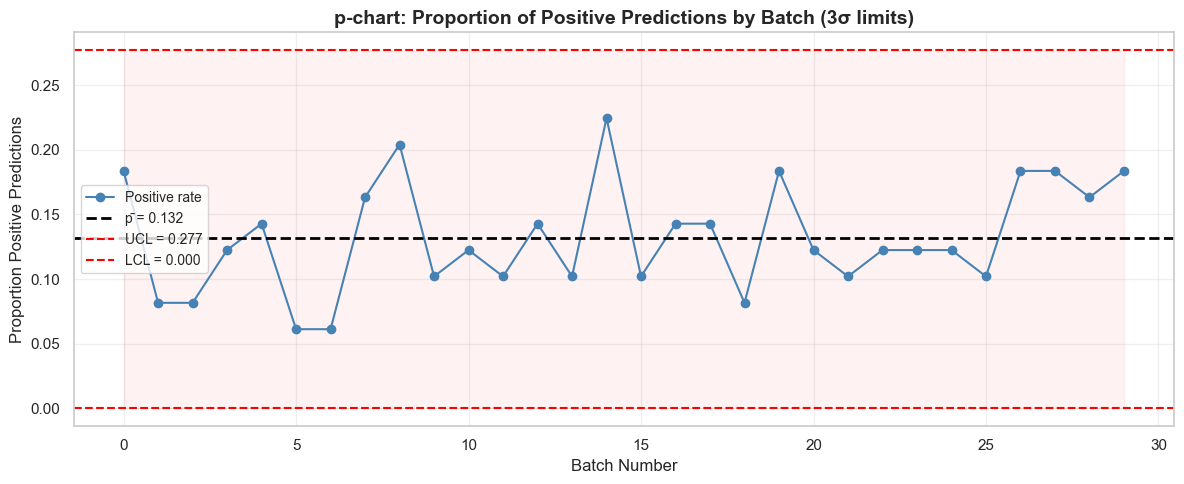

✓ No p-chart violations detected.


In [5]:
# Cell 5 — p-chart for positive prediction rate
# Monitor proportion of positive predictions with 3-sigma control limits

pbar = metrics_df['pos_rate'].mean()
n = metrics_df['n'].mean()  # Average sample size
z = 3  # 3-sigma control limits
sigma = np.sqrt(pbar * (1 - pbar) / n)
ucl = pbar + z * sigma
lcl = max(0, pbar - z * sigma)

plt.figure(figsize=(12, 5))
plt.plot(metrics_df['batch'], metrics_df['pos_rate'], marker='o', 
         color='steelblue', label='Positive rate', markersize=6)
plt.axhline(pbar, color='black', linestyle='--', linewidth=2, label=f'p̄ = {pbar:.3f}')
plt.axhline(ucl, color='red', linestyle='--', linewidth=1.5, label=f'UCL = {ucl:.3f}')
plt.axhline(lcl, color='red', linestyle='--', linewidth=1.5, label=f'LCL = {lcl:.3f}')
plt.fill_between(metrics_df['batch'], lcl, ucl, color='red', alpha=0.05)

plt.xlabel('Batch Number', fontsize=12)
plt.ylabel('Proportion Positive Predictions', fontsize=12)
plt.title('p-chart: Proportion of Positive Predictions by Batch (3σ limits)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/pchart_pos_rate.png', dpi=300, bbox_inches='tight')
plt.show()

# Check for violations
p_violations = metrics_df[(metrics_df['pos_rate'] > ucl) | (metrics_df['pos_rate'] < lcl)]
if len(p_violations) > 0:
    print(f'⚠️ p-chart violations detected in {len(p_violations)} batches:')
    print(p_violations[['batch', 'pos_rate']])
else:
    print('✓ No p-chart violations detected.')

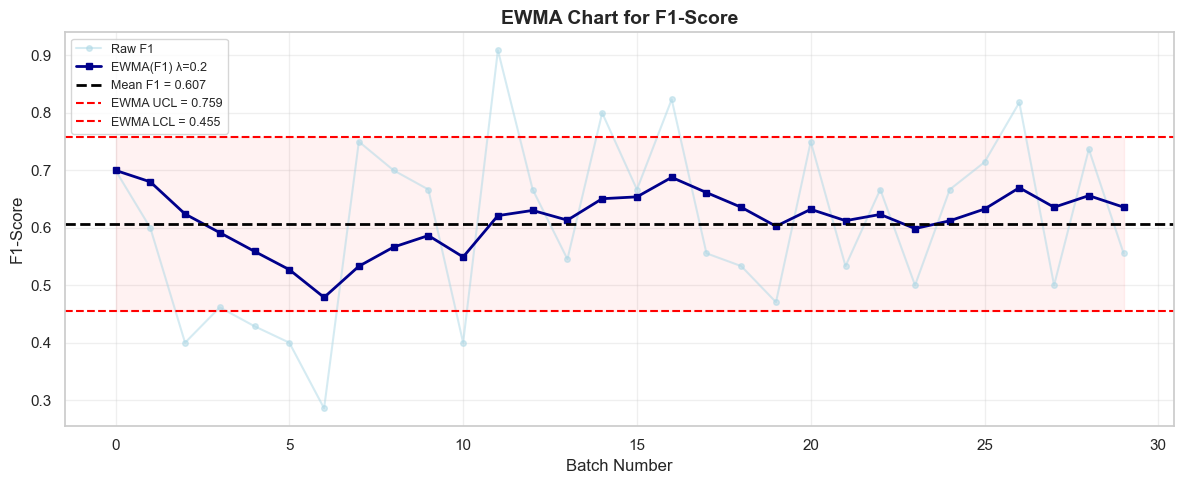

✓ No EWMA violations detected.


In [6]:
# Cell 6 — EWMA chart for F1-score
# Exponentially Weighted Moving Average to detect small sustained shifts

lambda_ = 0.2  # EWMA smoothing parameter
L = 3  # Control limit multiplier

f1 = metrics_df['f1'].fillna(0).values
z = np.zeros_like(f1)
z[0] = f1[0]

# Compute EWMA
for t in range(1, len(f1)):
    z[t] = lambda_ * f1[t] + (1 - lambda_) * z[t-1]

# Compute control limits
mu = np.mean(f1)
sigma0 = np.std(f1, ddof=1)
sigma_z = sigma0 * np.sqrt((lambda_ / (2 - lambda_)) * (1 - (1 - lambda_)**(2 * len(f1))))
ucl_ewma = mu + L * sigma_z
lcl_ewma = max(0, mu - L * sigma_z)

plt.figure(figsize=(12, 5))
plt.plot(metrics_df['batch'], f1, marker='o', color='lightblue', 
         alpha=0.5, label='Raw F1', markersize=4)
plt.plot(metrics_df['batch'], z, marker='s', color='darkblue', 
         label=f'EWMA(F1) λ={lambda_}', linewidth=2, markersize=5)
plt.axhline(mu, color='black', linestyle='--', linewidth=2, label=f'Mean F1 = {mu:.3f}')
plt.axhline(ucl_ewma, color='red', linestyle='--', linewidth=1.5, label=f'EWMA UCL = {ucl_ewma:.3f}')
plt.axhline(lcl_ewma, color='red', linestyle='--', linewidth=1.5, label=f'EWMA LCL = {lcl_ewma:.3f}')
plt.fill_between(metrics_df['batch'], lcl_ewma, ucl_ewma, color='red', alpha=0.05)

plt.xlabel('Batch Number', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('EWMA Chart for F1-Score', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/ewma_f1.png', dpi=300, bbox_inches='tight')
plt.show()

# Check for violations
ewma_violations = np.where((z > ucl_ewma) | (z < lcl_ewma))[0]
if len(ewma_violations) > 0:
    print(f'⚠️ EWMA violations detected in batches: {ewma_violations.tolist()}')
else:
    print('✓ No EWMA violations detected.')

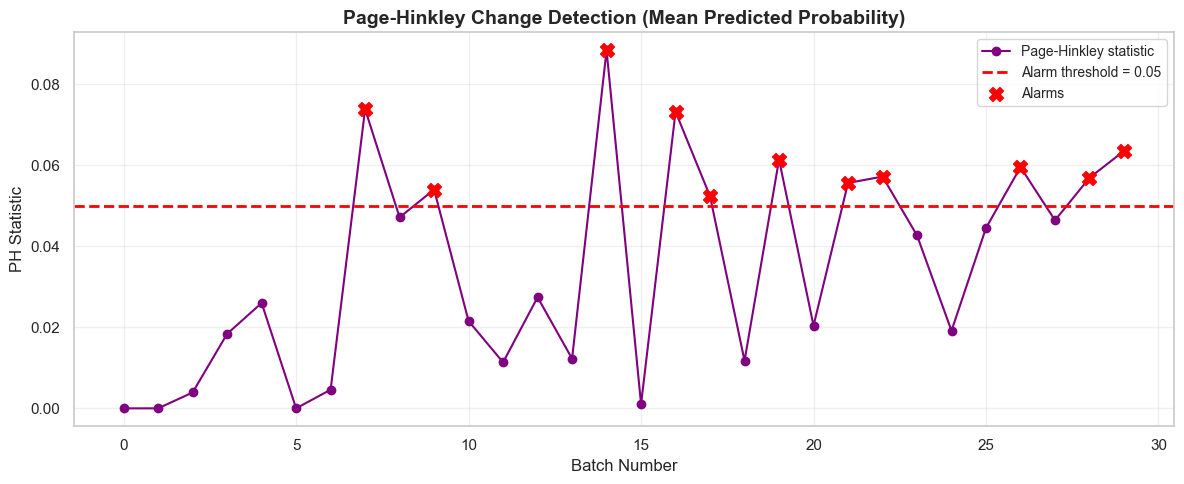

⚠️ Page-Hinkley alarms detected in batches: [7, 9, 14, 16, 17, 19, 21, 22, 26, 28, 29]


In [7]:
# Cell 7 — Page-Hinkley detector for mean predicted probability
# Detects mean shifts in continuous metrics

def page_hinkley(data, delta=0.005, threshold=0.05):
    """
    Page-Hinkley change detection algorithm.
    
    Parameters:
    - data: array of observations
    - delta: drift threshold (small positive value)
    - threshold: alarm threshold
    
    Returns:
    - ph_stat: list of PH statistics
    - alarm_indices: list of indices where alarm triggered
    """
    m = 0.0
    M = 1e9
    ph_stat = []
    alarm_indices = []
    
    for i, x in enumerate(data):
        m += (x - m) / (i + 1)
        diff = x - m - delta
        M = min(M, diff)
        ph = diff - M
        ph_stat.append(ph)
        
        if ph > threshold:
            alarm_indices.append(i)
    
    return ph_stat, alarm_indices

prob_mean = metrics_df['prob_mean'].values
ph_vals, ph_alarms = page_hinkley(prob_mean, delta=0.005, threshold=0.05)

plt.figure(figsize=(12, 5))
plt.plot(metrics_df['batch'], ph_vals, marker='o', color='purple', 
         label='Page-Hinkley statistic', markersize=6)
plt.axhline(0.05, color='red', linestyle='--', linewidth=2, label='Alarm threshold = 0.05')

# Mark alarm points
if len(ph_alarms) > 0:
    plt.scatter([metrics_df.loc[i, 'batch'] for i in ph_alarms], 
                [ph_vals[i] for i in ph_alarms],
                color='red', s=100, marker='X', zorder=5, label='Alarms')

plt.xlabel('Batch Number', fontsize=12)
plt.ylabel('PH Statistic', fontsize=12)
plt.title('Page-Hinkley Change Detection (Mean Predicted Probability)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/page_hinkley.png', dpi=300, bbox_inches='tight')
plt.show()

if len(ph_alarms) > 0:
    print(f'⚠️ Page-Hinkley alarms detected in batches: {ph_alarms}')
else:
    print('✓ No Page-Hinkley alarms detected.')

In [8]:
# Cell 8 — PSI (Population Stability Index) per feature
# Detects distribution shifts in numeric features

def psi(expected, actual, bins=10):
    """
    Calculate Population Stability Index.
    
    Parameters:
    - expected: reference distribution (training data)
    - actual: current distribution (batch data)
    - bins: number of bins for discretization
    
    Returns:
    - PSI value
    """
    # Create bins from expected distribution
    breakpoints = np.percentile(expected, np.linspace(0, 100, bins + 1))
    breakpoints = np.unique(breakpoints)  # Remove duplicates
    
    # Compute distributions
    expected_pct = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_pct = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    
    # Replace zeros to avoid division by zero
    expected_pct = np.where(expected_pct == 0, 1e-6, expected_pct)
    actual_pct = np.where(actual_pct == 0, 1e-6, actual_pct)
    
    # Calculate PSI
    psi_val = np.sum((actual_pct - expected_pct) * np.log(actual_pct / expected_pct))
    
    return psi_val

# Use first 3 batches as reference
ref = pd.concat(batches[:3])
print(f'Reference distribution: {len(ref)} observations from first 3 batches')

# Get numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns.drop([target_col]).tolist()
print(f'Monitoring {len(numeric_features)} numeric features for PSI')

# Compute PSI for each batch
psi_results = []
for i, batch in enumerate(batches):
    psi_batch = {'batch': i}
    for feat in numeric_features:
        psi_val = psi(ref[feat].values, batch[feat].values, bins=10)
        psi_batch[feat] = psi_val
    psi_results.append(psi_batch)

psi_df = pd.DataFrame(psi_results)
psi_df.to_csv('../tables/psi_by_batch.csv', index=False)

print('\nPSI computed for all batches.')
print('\nTop 10 features by mean PSI:')
psi_means = psi_df.drop(columns='batch').mean().sort_values(ascending=False).head(10)
print(psi_means)

Reference distribution: 147 observations from first 3 batches
Monitoring 26 numeric features for PSI

PSI computed for all batches.

Top 10 features by mean PSI:
MonthlyIncome           0.518497
YearsAtCompany          0.450871
HourlyRate              0.427909
MonthlyRate             0.384530
TotalWorkingYears       0.378031
Age                     0.355617
DistanceFromHome        0.313474
YearsWithCurrManager    0.297179
EmployeeNumber          0.296580
DailyRate               0.287216
dtype: float64


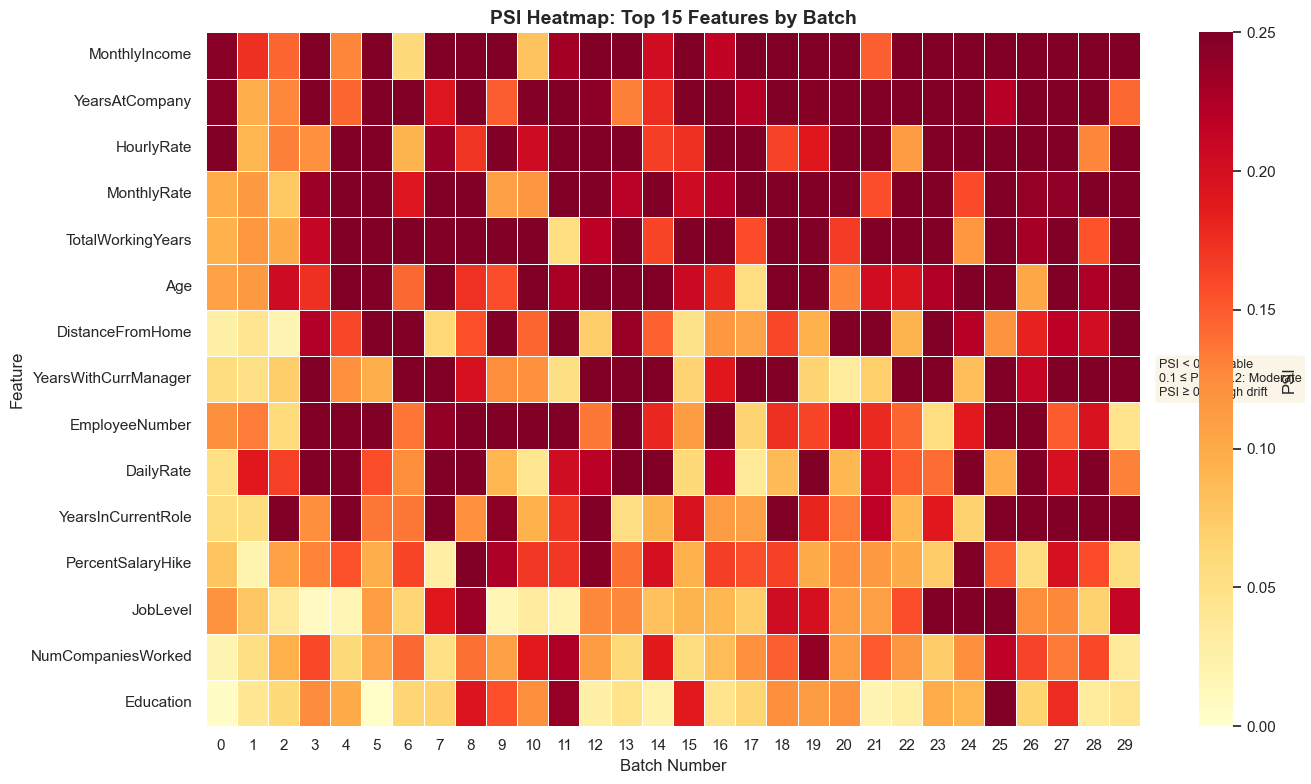


Batches with high PSI (≥0.2) in any feature: 29
Batches with moderate PSI (0.1-0.2) in any feature: 30

⚠️ High PSI detected in batches: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [9]:
# Cell 9 — PSI heatmap visualization
# Visualize PSI trends across batches and features

# Select top features by mean PSI
top_feats = psi_df.drop(columns='batch').mean().sort_values(ascending=False).head(15).index.tolist()

plt.figure(figsize=(14, 8))
sns.heatmap(psi_df.set_index('batch')[top_feats].T, 
            cmap='YlOrRd', annot=False, cbar_kws={'label': 'PSI'},
            vmin=0, vmax=0.25, linewidths=0.5)
plt.xlabel('Batch Number', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('PSI Heatmap: Top 15 Features by Batch', fontsize=14, fontweight='bold')

# Add threshold lines as text
plt.text(1.02, 0.5, 'PSI < 0.1: Stable\n0.1 ≤ PSI < 0.2: Moderate\nPSI ≥ 0.2: High drift', 
         transform=plt.gca().transAxes, fontsize=9, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('../figures/psi_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Check for high PSI violations
high_psi = psi_df.set_index('batch').apply(lambda row: (row >= 0.2).sum(), axis=1)
moderate_psi = psi_df.set_index('batch').apply(lambda row: ((row >= 0.1) & (row < 0.2)).sum(), axis=1)

print(f'\nBatches with high PSI (≥0.2) in any feature: {(high_psi > 0).sum()}')
print(f'Batches with moderate PSI (0.1-0.2) in any feature: {(moderate_psi > 0).sum()}')

if (high_psi > 0).any():
    print('\n⚠️ High PSI detected in batches:', high_psi[high_psi > 0].index.tolist())
else:
    print('\n✓ No high PSI violations detected.')

Monitoring 8 categorical features for KL divergence

KL divergence computed for all batches.

Mean KL divergence by feature:
JobRole           0.202530
EducationField    0.142686
Department        0.077503
MaritalStatus     0.033857
BusinessTravel    0.024731
Gender            0.019498
OverTime          0.008201
Over18            0.000000
dtype: float64


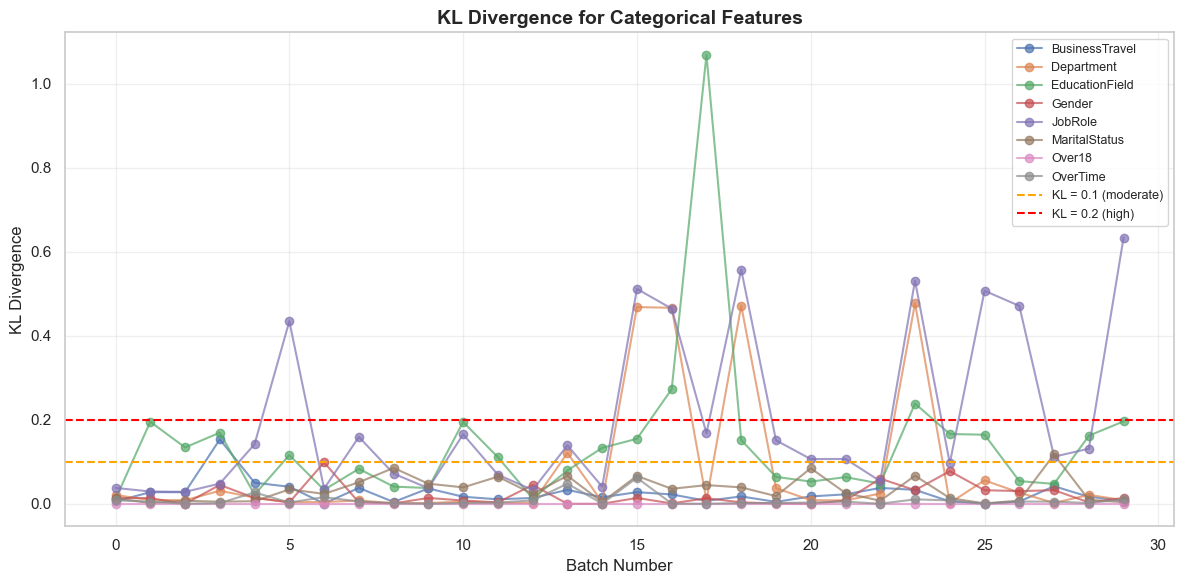


⚠️ High KL divergence (≥0.2) detected in batches: [5, 15, 16, 17, 18, 23, 25, 26, 29]


In [10]:
# Cell 10 — KL divergence for categorical features
# Monitor distribution shifts in categorical variables

# Get categorical features
cat_features = [c for c in df.columns if df[c].dtype == 'object' and c != target_col]
print(f'Monitoring {len(cat_features)} categorical features for KL divergence')

kl_results = []
for i, batch in enumerate(batches):
    kl_row = {'batch': i}
    for feat in cat_features:
        # Get distributions
        ref_dist = ref[feat].value_counts(normalize=True)
        batch_dist = batch[feat].value_counts(normalize=True)
        
        # Align indices
        all_idx = sorted(set(ref_dist.index).union(set(batch_dist.index)))
        p = np.array([ref_dist.get(k, 1e-6) for k in all_idx])
        q = np.array([batch_dist.get(k, 1e-6) for k in all_idx])
        
        # Compute KL divergence
        kl = entropy(p, q)  # KL(P||Q)
        kl_row[feat] = kl
    kl_results.append(kl_row)

kl_df = pd.DataFrame(kl_results)
kl_df.to_csv('../tables/kl_by_batch.csv', index=False)

print('\nKL divergence computed for all batches.')
print('\nMean KL divergence by feature:')
kl_summary = kl_df.drop(columns='batch').mean().sort_values(ascending=False)
print(kl_summary)

# Visualize KL trends
if len(cat_features) > 0:
    plt.figure(figsize=(12, 6))
    for feat in cat_features:
        plt.plot(kl_df['batch'], kl_df[feat], marker='o', label=feat, alpha=0.7)
    
    plt.axhline(0.1, color='orange', linestyle='--', linewidth=1.5, label='KL = 0.1 (moderate)')
    plt.axhline(0.2, color='red', linestyle='--', linewidth=1.5, label='KL = 0.2 (high)')
    
    plt.xlabel('Batch Number', fontsize=12)
    plt.ylabel('KL Divergence', fontsize=12)
    plt.title('KL Divergence for Categorical Features', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../figures/kl_divergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Check for violations
    high_kl = kl_df.set_index('batch').apply(lambda row: (row >= 0.2).sum(), axis=1)
    if (high_kl > 0).any():
        print('\n⚠️ High KL divergence (≥0.2) detected in batches:', high_kl[high_kl > 0].index.tolist())
    else:
        print('\n✓ No high KL divergence violations detected.')

In [11]:
# Cell 11 — Optional ADWIN detector (requires river library)
# Adaptive Windowing for streaming drift detection

try:
    from river.drift import ADWIN
    
    adwin = ADWIN()
    adwin_alerts = []
    
    # Feed mean predicted probability stream
    for i, val in enumerate(metrics_df['prob_mean'].values):
        adwin.update(val)
        if adwin.change_detected:
            adwin_alerts.append(i)
    
    if len(adwin_alerts) > 0:
        print(f'⚠️ ADWIN drift alarms detected in batches: {adwin_alerts}')
        print('   These are high-priority alerts indicating distribution changes.')
    else:
        print('✓ No ADWIN drift alarms detected.')
        
except ImportError:
    print('ℹ️ ADWIN detector not available.')
    print('   Install river library with: pip install river')
    adwin_alerts = []
except Exception as e:
    print(f'⚠️ ADWIN error: {e}')
    adwin_alerts = []

ℹ️ ADWIN detector not available.
   Install river library with: pip install river


In [12]:
# Cell 12 — Alert logic and summary report
# Consolidate all monitoring alerts

alerts = []

# p-chart alerts
p_alerts = metrics_df[(metrics_df['pos_rate'] > ucl) | (metrics_df['pos_rate'] < lcl)]['batch'].tolist()
if p_alerts:
    alerts.append({
        'type': 'p_chart',
        'severity': 'MEDIUM',
        'batches': p_alerts,
        'description': 'Positive prediction rate outside 3σ control limits'
    })

# EWMA alerts
ewma_alerts_list = list(metrics_df['batch'][ewma_violations])
if ewma_alerts_list:
    alerts.append({
        'type': 'ewma',
        'severity': 'HIGH',
        'batches': ewma_alerts_list,
        'description': 'EWMA F1-score outside control limits (sustained drift)'
    })

# Page-Hinkley alerts
if ph_alarms:
    alerts.append({
        'type': 'page_hinkley',
        'severity': 'HIGH',
        'batches': ph_alarms,
        'description': 'Mean shift detected in predicted probabilities'
    })

# PSI alerts (high drift)
psi_alarms = []
for idx, row in psi_df.iterrows():
    high_feats = row.drop('batch')[row.drop('batch') >= 0.2].index.tolist()
    if len(high_feats) > 0:
        psi_alarms.append({
            'batch': int(row['batch']),
            'features': high_feats,
            'max_psi': row[high_feats].max()
        })

if psi_alarms:
    alerts.append({
        'type': 'psi',
        'severity': 'HIGH',
        'batches': [a['batch'] for a in psi_alarms],
        'description': 'PSI ≥ 0.2 detected (high feature drift)',
        'details': psi_alarms
    })

# KL divergence alerts (if applicable)
if len(cat_features) > 0:
    kl_alarms = []
    for idx, row in kl_df.iterrows():
        high_kl_feats = row.drop('batch')[row.drop('batch') >= 0.2].index.tolist()
        if len(high_kl_feats) > 0:
            kl_alarms.append({
                'batch': int(row['batch']),
                'features': high_kl_feats
            })
    
    if kl_alarms:
        alerts.append({
            'type': 'kl_divergence',
            'severity': 'MEDIUM',
            'batches': [a['batch'] for a in kl_alarms],
            'description': 'KL divergence ≥ 0.2 in categorical features'
        })

# ADWIN alerts
if adwin_alerts:
    alerts.append({
        'type': 'adwin',
        'severity': 'CRITICAL',
        'batches': adwin_alerts,
        'description': 'ADWIN streaming drift alarm (immediate investigation required)'
    })

print('\n' + '='*60)
print('MONITORING ALERT SUMMARY')
print('='*60)

if len(alerts) == 0:
    print('✓ No alerts detected. All monitoring metrics within acceptable bounds.')
else:
    print(f'⚠️ Total alerts: {len(alerts)}\n')
    for i, alert in enumerate(alerts, 1):
        print(f'{i}. [{alert["severity"]}] {alert["type"].upper()}')
        print(f'   Description: {alert["description"]}')
        print(f'   Affected batches: {alert["batches"]}')
        if 'details' in alert:
            print(f'   Details: {alert["details"]}')
        print()

# Export report
report = {
    'monitoring_date': '2025-10-02',
    'n_batches': len(batches),
    'total_observations': len(df),
    'metrics_summary': metrics_df[['f1', 'recall', 'precision', 'roc_auc', 'pos_rate']].describe().to_dict(),
    'alerts': alerts,
    'psi_summary': psi_df.drop(columns='batch').mean().sort_values(ascending=False).head(10).to_dict(),
    'kl_summary': kl_df.drop(columns='batch').mean().to_dict() if len(cat_features) > 0 else {}
}

with open('../reports/control_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print('\n✓ Control report saved to: reports/control_report.json')


MONITORING ALERT SUMMARY
⚠️ Total alerts: 3

1. [HIGH] PAGE_HINKLEY
   Description: Mean shift detected in predicted probabilities
   Affected batches: [7, 9, 14, 16, 17, 19, 21, 22, 26, 28, 29]

2. [HIGH] PSI
   Description: PSI ≥ 0.2 detected (high feature drift)
   Affected batches: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
   Details: [{'batch': 0, 'features': ['HourlyRate', 'MonthlyIncome', 'YearsAtCompany'], 'max_psi': np.float64(0.29705959917395364)}, {'batch': 2, 'features': ['Age', 'YearsInCurrentRole'], 'max_psi': np.float64(0.3293070761106084)}, {'batch': 3, 'features': ['DailyRate', 'DistanceFromHome', 'EmployeeNumber', 'MonthlyIncome', 'MonthlyRate', 'TotalWorkingYears', 'YearsAtCompany', 'YearsWithCurrManager'], 'max_psi': np.float64(0.46643552256883053)}, {'batch': 4, 'features': ['Age', 'DailyRate', 'EmployeeNumber', 'HourlyRate', 'MonthlyRate', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsInCurre

## Summary & Next Steps

### Deliverables
- **Figures:** p-chart, EWMA, Page-Hinkley, PSI heatmap, KL divergence plots saved to `figures/`
- **Tables:** Batch metrics, PSI, KL divergence saved to `tables/`
- **Report:** JSON alert summary saved to `reports/control_report.json`

### Operational Recommendations
1. **Tune parameters** on historical data:
   - EWMA λ (currently 0.2)
   - Page-Hinkley delta and threshold (currently 0.005 and 0.05)
   - PSI bins and thresholds

2. **Integrate with production monitoring stack:**
   - Wire metrics to Prometheus/Grafana dashboards
   - Configure PagerDuty/Slack alerts for CRITICAL/HIGH severity
   - Use Evidently for automated drift reports

3. **Establish retraining triggers:**
   - Performance drop: F1 below LCL for 3 consecutive weeks
   - Drift evidence: PSI ≥ 0.2 on any feature OR PSI ≥ 0.1 on >3 features
   - Data volume: ≥500 new labeled observations
   - Quarterly schedule (if no triggers)

4. **Assign ownership:**
   - Model Owner (Data Scientist): threshold tuning, triage, retraining
   - Data Owner (HR/Domain): verify data changes, business context
   - MLOps Lead: deployment, rollback, logging

5. **Test rollback procedures:**
   - Maintain last 3 model versions
   - Document blue/green deployment process
   - Practice incident response drills

### Reference Documents
- Full control plan: `paper/appendix_control_plan.md`
- Model metadata: `models/model_metadata.json`
- Final model: `models/final_attrition_pipeline.pkl`